In [894]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy.special import erfc
from scipy import stats
from sympy import *

sys.path.append('AppStat2023/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [895]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [896]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

In [897]:
def fit_and_plot(f, x, y, sy, par_guess, labels):
    """Function for making and plotting a chi2-fit."""
    
    Minuit.print_level = 1

    chi2fit = Chi2Regression(f, x, y, sy)

    minuit_chi2 = Minuit(chi2fit, **par_guess)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output


    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value = len(y) - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

    fig, ax = plt.subplots(figsize=(9, 6))  # figsize is in inches
    ax.errorbar(x, y, yerr=sy, label='Data', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

    # Set the figure texts; xlabel, ylabel and title.
    ax.set(xlabel=f"{labels[0]}", # the label of the y axis
        ylabel=f"{labels[1]}",  # the label of the y axis
        title=f"{labels[2]}")

    # Adding fit function to plot:
    x_axis = np.linspace(np.min(x), np.max(x), 1000)
    ax.plot(x_axis, f(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

    # Adding fit results to plot:
    d = {'Chi2':     minuit_chi2.fval  ,
        'ndf':      len(y)-minuit_chi2.nfit,
        'Prob':     stats.chi2.sf(minuit_chi2.fval, len(y)-minuit_chi2.nfit),
        }

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.62, 0.95, text, ax, fontsize=12)

    ax.legend(loc='upper left', fontsize=12);
    fig.tight_layout()

In [898]:
def fit(f, x, y, sy, par_guess):
    """Function for making a chi2-fit."""
    
    Minuit.print_level = 1

    chi2fit = Chi2Regression(f, x, y, sy)

    minuit_chi2 = Minuit(chi2fit, **par_guess)
    minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
    minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output


    for name in minuit_chi2.parameters :
        value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
        print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

    # Get Chi2 value:
    chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

    # Get number of degrees-of-freedom (Ndof):
    Ndof_value = len(y) - minuit_chi2.nfit

    Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

    return minuit_chi2


def plot(f, x, y, sy, labels):
    """Function for making a nice plot of a fit"""
    fig, ax = plt.subplots(figsize=(9, 6))  # figsize is in inches
    ax.errorbar(x, y, yerr=sy, label='Data', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

    # Set the figure texts; xlabel, ylabel and title.
    ax.set(xlabel=f"{labels[0]}", # the label of the y axis
        ylabel=f"{labels[1]}",  # the label of the y axis
        title=f"{labels[2]}")

    # Adding fit function to plot:
    x_axis = np.linspace(np.min(x), np.max(x), 1000)
    ax.plot(x_axis, f(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

    # Adding fit results to plot:
    d = {'Chi2':     minuit_chi2.fval  ,
        'ndf':      len(y)-minuit_chi2.nfit,
        'Prob':     stats.chi2.sf(minuit_chi2.fval, len(y)-minuit_chi2.nfit),
        }

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.62, 0.95, text, ax, fontsize=12)

    ax.legend(loc='upper left', fontsize=12);
    fig.tight_layout()

In [899]:
def chauvenet(x, ex, p_reject):

    x_subset = np.copy(x)
    x_subset_updated = np.zeros(len(x))
    ex_subset = np.copy(ex)
    ex_subset_updated = np.zeros(len(ex))
    x_rejected = []
    p_rejected = []

    while True:

        mean = np.mean(x_subset)
        sigma = np.std(x_subset, ddof=1)

        for j in range(len(x_subset)):
            p = len(x_subset) * erfc(np.abs(x_subset[j]-mean)/sigma)
            if p < p_reject:
                x_rejected.append(x_subset[j])
                p_rejected.append(p)
                x_subset_updated = np.delete(x_subset, j)
                ex_subset_updated = np.delete(ex_subset, j)
        
        if len(x_subset_updated) == len(x_subset):
            break
        else:
            x_subset = x_subset_updated
            ex_subset = x_subset_updated


    print(f"  The number of measurements used before and after is: {len(x):d} and {len(x_subset):d}")
    print(f"  This means that {(len(x)-len(x_subset)):d} measurements have been removed")

    return x_subset, ex_subset, x_rejected, p_rejected

In [900]:
def print_relation(R, name):
    """Print relation"""
    lprint(latex(Eq(symbols(name),R)))

def propagate_error(F, PAR, COV):

    variance_total = 0
    each_contrib = []

    for i in range(len(PAR)):
        for j in range(len(PAR)):
            variance = F.diff(PAR[i]) * F.diff(PAR[j]) * COV[i, j]
            variance_total += F.diff(PAR[i]) * F.diff(PAR[j]) * COV[i, j]
            each_contrib.append(variance)

    return sqrt(variance_total), each_contrib


In [901]:
# Calculate ROC curve from two histograms (hist1 is signal, hist2 is background):
def calc_ROC(hist1, hist2) :

    # First we extract the entries (y values) and the edges of the histograms:
    # Note how the "_" is simply used for the rest of what e.g. "hist1" returns (not really of our interest)
    y_sig, x_sig_edges, _ = hist1 
    y_bkg, x_bkg_edges, _ = hist2
    
    # Check that the two histograms have the same x edges:
    if np.array_equal(x_sig_edges, x_bkg_edges) :
        
        # Extract the center positions (x values) of the bins (both signal or background works - equal binning)
        x_centers = 0.5*(x_sig_edges[1:] + x_sig_edges[:-1])
        
        # Calculate the integral (sum) of the signal and background:
        integral_sig = y_sig.sum()
        integral_bkg = y_bkg.sum()
    
        # Initialize empty arrays for the True Positive Rate (TPR) and the False Positive Rate (FPR):
        TPR = np.zeros_like(y_sig) # True positive rate (sensitivity)
        FPR = np.zeros_like(y_sig) # False positive rate ()
        
        # Loop over all bins (x_centers) of the histograms and calculate TN, FP, FN, TP, FPR, and TPR for each bin:
        for i, x in enumerate(x_centers): 
            
            # The cut mask
            cut = (x_centers < x)
            
            # True positive
            TP = np.sum(y_sig[~cut]) / integral_sig    # True positives
            FN = np.sum(y_sig[cut]) / integral_sig     # False negatives
            TPR[i] = TP / (TP + FN)                    # True positive rate
            
            # True negative
            TN = np.sum(y_bkg[cut]) / integral_bkg      # True negatives (background)
            FP = np.sum(y_bkg[~cut]) / integral_bkg     # False positives
            FPR[i] = FP / (FP + TN)                     # False positive rate            
            
        return FPR, TPR
    
    else:
        AssertionError("Signal and Background histograms have different bins and/or ranges")

### Problem 1.1

In [902]:
p = 1/6  # probability of success
n = 4  # number of trials
k = 1  # number of successes

prob = stats.binom.pmf(k, n, p) + stats.binom.pmf(k+1, n, p) + stats.binom.pmf(k+2, n, p) + stats.binom.pmf(k+3, n, p)
print(f"The probability to win in the first game is {prob:.4f} = {prob*100:.2f} %.")

The probability to win in the first game is 0.5177 = 51.77 %.


In [903]:
p = 1/6 * 1/6  # probability of success
n = 24  # number of trials
k = 1  # number of successes

prob = 0
for i in range(k, n+1):
    prob += stats.binom.pmf(i, n, p)

print(f"The probability to win in the second game is {prob:.4f} = {prob*100:.2f} %.")

The probability to win in the second game is 0.4914 = 49.14 %.


### Problem 1.2

In [904]:
mu = 18.9
k = 42
N = 1730

def p_global(p_local, N):
    return 1 - (1 - p_local)**N

prob = stats.poisson.sf(k, mu)
print(f"The probability to see 42 or more events in a day is {prob}")
print(f"The global significance of this is {p_global(prob, N)}")

The probability to see 42 or more events in a day is 1.3718502458083341e-06
The global significance of this is 0.0023704884973593243


### Problem 1.3

In [905]:
mu = 1.68
sig = 0.06

frac = stats.norm.sf(1.85, loc=mu, scale=sig)
print(f"The fraction of women taller than 1.85 m is {frac:.6f} = {frac*100:.6f} %")

The fraction of women taller than 1.85 m is 0.002303 = 0.230327 %


The average height of the 20 % tallest women is 1.7642 +- 0.004


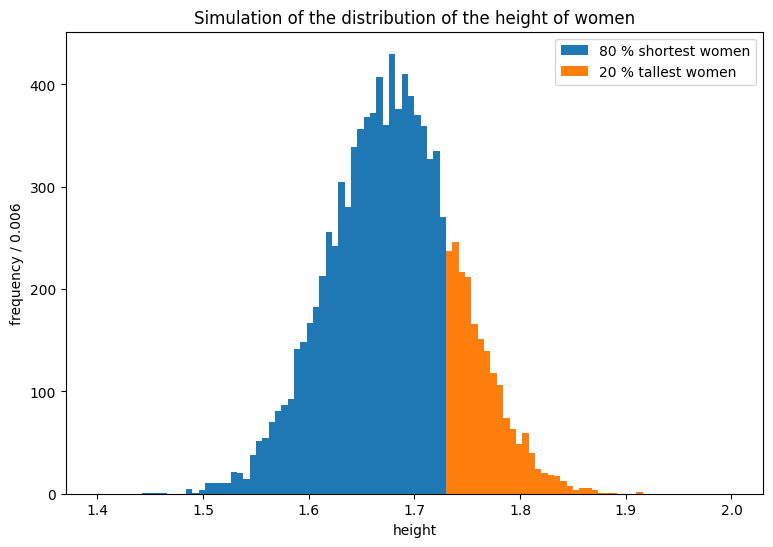

In [906]:
N_points = 10000
simulated_heights = np.random.normal(mu, sig, N_points)
Nbins = 100
xmin = 1.4
xmax = 2.0

sorted_heights = np.sort(simulated_heights)[::-1]

top_20_percent_index = int(0.2 * N_points)
top_heights = sorted_heights[:top_20_percent_index+1]

print(f"The average height of the 20 % tallest women is {np.mean(top_heights):.4f} +- {np.sqrt(0.20*(1-0.20)/N_points)}")

fig, ax = plt.subplots(figsize=(9,6));
ax.hist(sorted_heights[top_20_percent_index:], bins=Nbins, range=(xmin, xmax), label="80 % shortest women");
ax.hist(sorted_heights[:top_20_percent_index+1], bins=Nbins, range=(xmin, xmax), label="20 % tallest women");
ax.set(ylabel=f"frequency / {(xmax-xmin)/Nbins:.3f}", xlabel="height", title="Simulation of the distribution of the height of women")
ax.legend()


### Problem 2.1

In [907]:
L, r, pi = symbols("L, r, pi")
dL, dr = symbols("sigma_L, sigma_r")

R = L * 1 / (pi * r**2)

par = np.array([L, r])
cov = np.array([[dL**2, 0], [0, dr**2]])

print_relation(R, "R")
dR, _ = propagate_error(R, par, cov)
print_relation(dR, "sigma_R")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Problem 2.2

In [908]:
measurement = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
result = np.array([3.61, 2.00, 3.90, 2.23, 2.32, 2.48, 2.43, 3.86, 4.43, 3.78]) * 10**2

av_v = np.mean(result)
sig_v = np.std(result, ddof=1) / np.sqrt(len(result))

print(f"The average speed is {av_v:.4f} +- {sig_v:.4f}")

The average speed is 310.4000 +- 28.1216


In [909]:
m, v = symbols("m, v")
dm, dv = symbols("sigma_m, sigma_v")

E = 1/2 * m * v**2

par = np.array([m, v])
cov = np.array([[dm**2, 0], [0, dv**2]])

print_relation(E, "E")
dE, con = propagate_error(E, par, cov)
print_relation(dE, "sigma_E")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [910]:
v_m, v_dm = 8.4*10**(-3), 0.5*10**(-3)
v_v, v_dv = av_v, sig_v

f_E = lambdify((m, v), E)
f_dE = lambdify((m, v, dm, dv), dE)

print(f"E = {f_E(v_m, v_v):.4f} +- {f_dE(v_m, v_v, v_dm, v_dv):.4f}")

E = 404.6623 +- 77.1783


In [911]:
f_con = lambdify((m, v, dm, dv), con)

print(f"The contribution from the mass is {np.sqrt(f_con(v_m, v_v, v_dm, v_dv)[0])}")
print(f"The contribution from the speed is {np.sqrt(f_con(v_m, v_v, v_dm, v_dv)[-1])}")
print("")
print(f"The factor that the velocity on v should drop is {np.sqrt(f_con(v_m, v_v, v_dm, v_dv)[-1]) / np.sqrt(f_con(v_m, v_v, v_dm, v_dv)[0])}")
print(f"The number of measurements needed are {(np.sqrt(f_con(v_m, v_v, v_dm, v_dv)[-1]) / np.sqrt(f_con(v_m, v_v, v_dm, v_dv)[0]))**2}")

The contribution from the mass is 24.087039999999995
The contribution from the speed is 73.32324067863841

The factor that the velocity on v should drop is 3.0440951100109617
The number of measurements needed are 9.26651503879265


### Problem 3.1

In [912]:
def f(x, C=0.2431339098):
    return C * x**(-0.9)

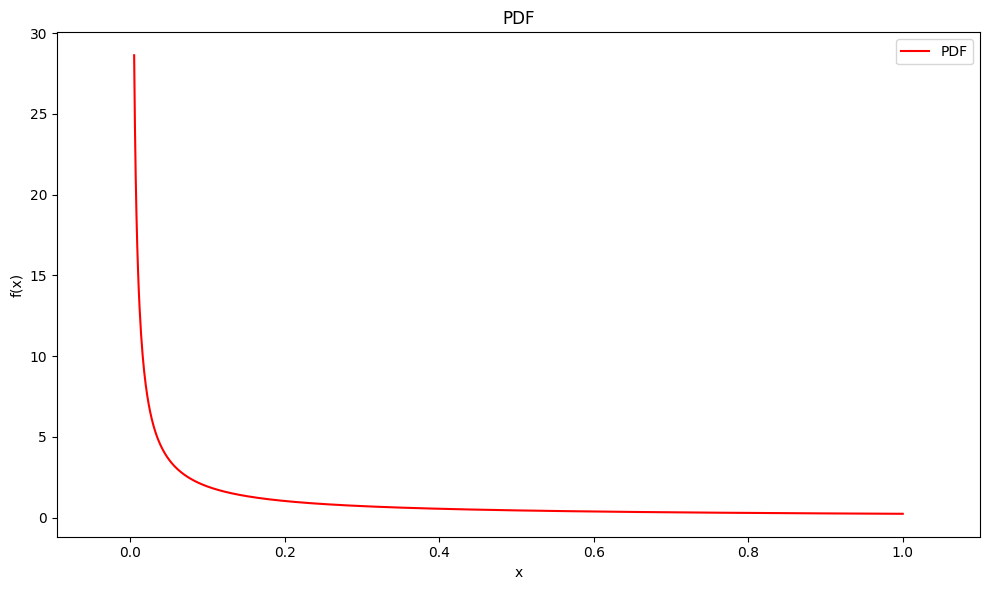

In [913]:
xmin = 0.005
xmax = 1

xaxis = np.linspace(xmin, xmax, 1000)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel="x", ylabel="f(x)", xlim=(xmin-0.1, xmax+0.1), title="PDF");

# Plot f(x)
x_axis = np.linspace(xmin, xmax, 1000)
y_axis = f(x_axis)
ax.plot(x_axis, y_axis, 'r-', label='PDF')

# Add legend
ax.legend(loc='best')
fig.tight_layout()

In [914]:
N_points = 10000

N_try = 0
ymin = 0.0      # Minimum value the function will take!
ymax = f(xmin)     # Maximum value the function will take!
x_pdf = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = np.random.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = np.random.uniform(ymin, ymax)
        
        if (y_test < f(x_test)):
            break
            
    x_pdf[i] = x_test

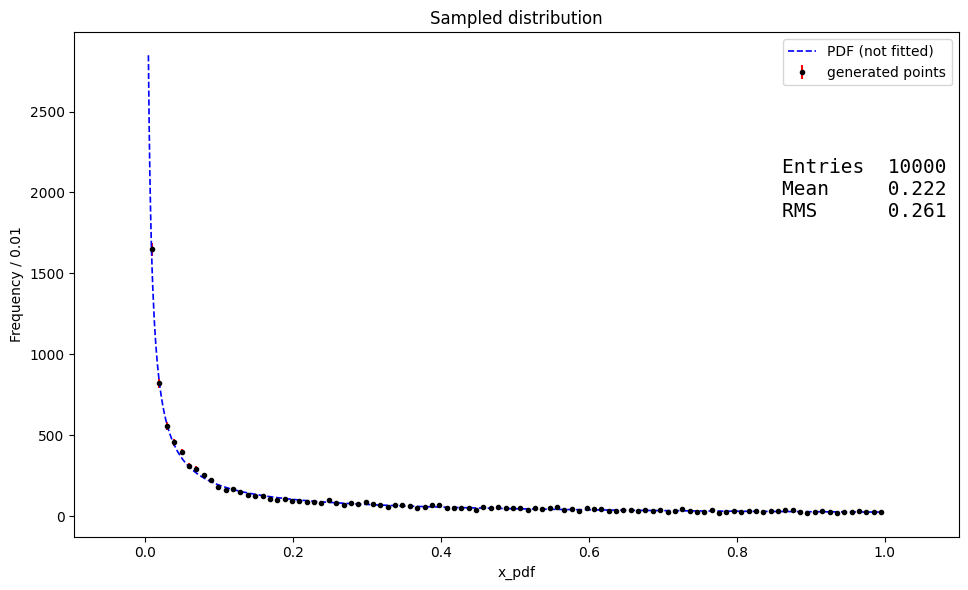

In [915]:
N_bins = 100
binwidth = (xmax-xmin)/N_bins
xmin = 0.005
xmax = 1

def f_hist(x):
    """This function is for plotting the histogram of the pdf"""
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N * f(x)

xaxis = np.linspace(xmin, xmax, 1000)

counts, bin_edges = np.histogram(x_pdf, bins=N_bins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(x, y, yerr=sy, fmt="k.", ecolor="red", label='generated points', lw=1.5)
ax.plot(xaxis, f_hist(xaxis), 'b--', lw = 1.2, label='PDF (not fitted)')
ax.set(xlabel="x_pdf", ylabel=f"Frequency / {binwidth:.2f}", xlim=(xmin-0.1, xmax+0.1), title="Sampled distribution");

# Define figure text
d = {'Entries': len(x_pdf),
     'Mean': x_pdf.mean(),
     'RMS': x_pdf.std(ddof=1),
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.8, 0.75, text, ax, fontsize=14)

# Add legend
ax.legend(loc='best')
fig.tight_layout()

In [916]:
def sample_50_and_sum():
    N_points = 50

    N_try = 0
    ymin = 0.0      # Minimum value the function will take!
    ymax = f(xmin)     # Maximum value the function will take!
    x_pdf = np.zeros(N_points)

    for i in range(N_points):
        
        while True:
            
            # Count the number of tries, to get efficiency/integral
            N_try += 1                    
            
            # Range that f(x) is defined/wanted in:
            x_test = np.random.uniform(xmin, xmax)  
            
            # Upper bound for function values:
            y_test = np.random.uniform(ymin, ymax)
            
            if (y_test < f(x_test)):
                break
                
        x_pdf[i] = x_test
    
    return np.sum(x_pdf)

In [917]:
t = np.zeros(1000)

for i in range(1000):
    t[i] = sample_50_and_sum()

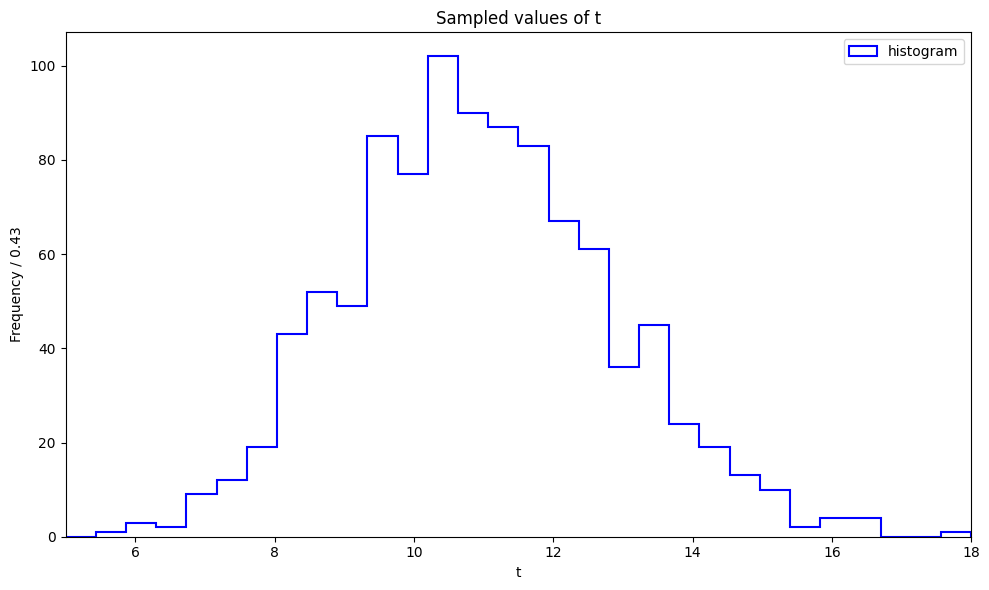

In [918]:
N_bins = 30
xmin = 5
xmax = 18
binwidth = (xmax-xmin)/N_bins

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel="t", ylabel=f"Frequency / {binwidth:.2f}", xlim=(xmin, xmax), title="Sampled values of t");

ax.hist(t, bins=N_bins, range=(xmin, xmax), histtype='step', color="blue", label='histogram', lw=1.5)

# Add legend
ax.legend(loc='best')
fig.tight_layout()

Fit value: mu = 10.92640 +/- 0.05849
Fit value: sigma = 1.81142 +/- 0.04233
Chi2 value: 31.2   Ndof = 25    Prob(Chi2,Ndof) = 0.1812737057188107


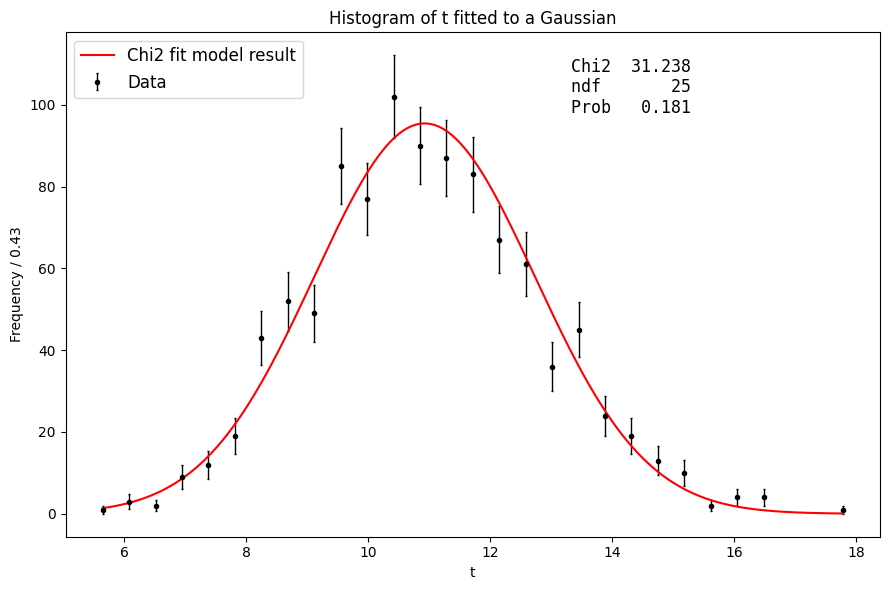

In [919]:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    N = (xmax-xmin)/N_bins * len(t)
    return  N * 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(t, bins=N_bins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

fit_and_plot(gauss_pdf, x, y, sy, {"mu":12.0, "sigma":2.0}, ["t", f"Frequency / {(xmax-xmin)/N_bins:.2f}", "Histogram of t fitted to a Gaussian"])

### Problem 4.1

In [920]:
data = np.genfromtxt("data_FisherSyndrome.txt")
index = data[:,0]
A = data[:,2]
B = data[:,3]
C = data[:,4]

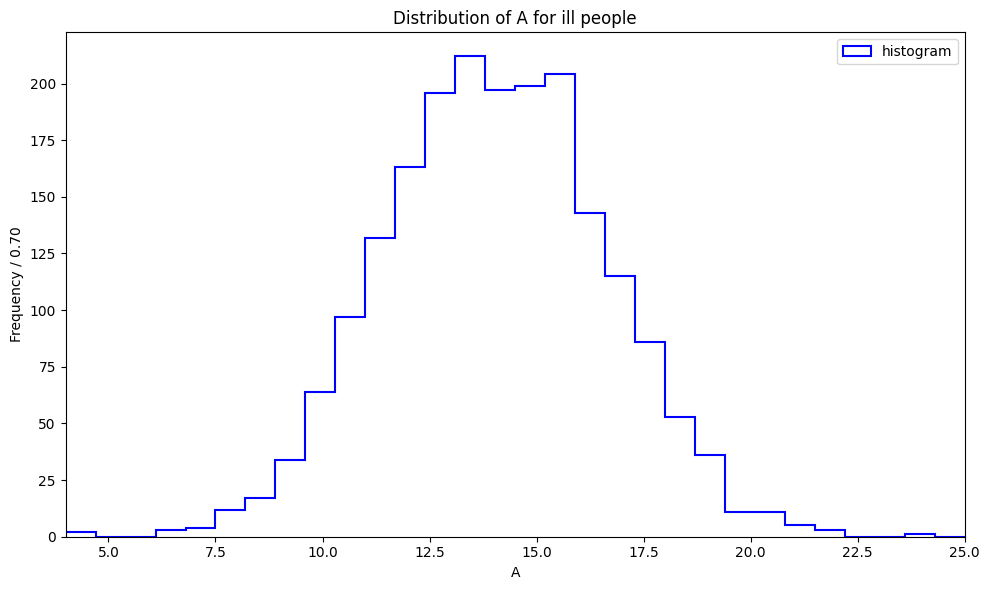

In [921]:
N_bins = 30
xmin = 4
xmax = 25
binwidth = (xmax-xmin)/N_bins

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel="A", ylabel=f"Frequency / {binwidth:.2f}", xlim=(xmin, xmax), title="Distribution of A for ill people");

ax.hist(A[index==1], bins=N_bins, range=(xmin, xmax), histtype='step', color="blue", label='histogram', lw=1.5)

# Add legend
ax.legend(loc='best')
fig.tight_layout()

25
Fit value: mu = 14.03919 +/- 0.05705
Fit value: sigma = 2.53871 +/- 0.04078
Chi2 value: 16.8   Ndof = 23    Prob(Chi2,Ndof) = 0.8186577071764513


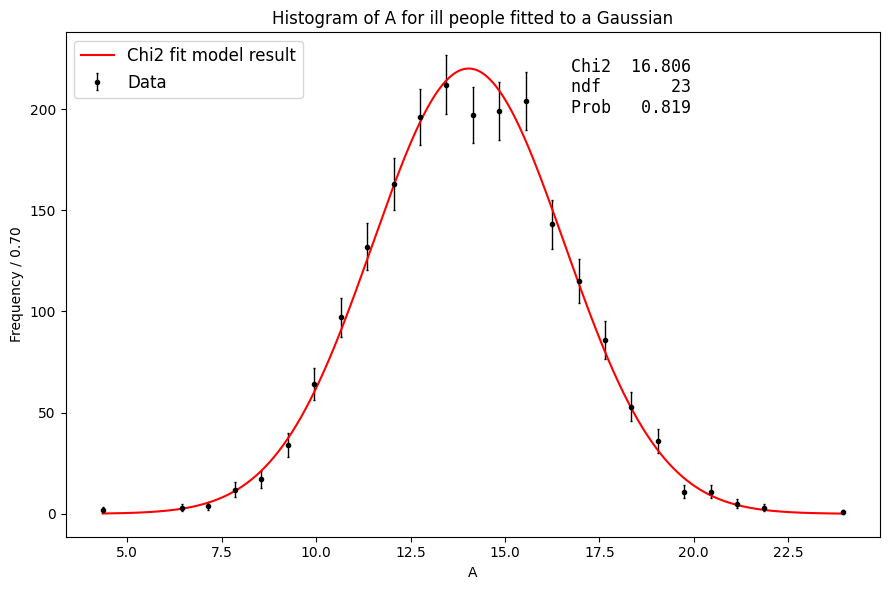

In [922]:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    N = (xmax-xmin)/N_bins * len(A[index==1])
    return  N * 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(A[index==1], bins=N_bins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
print(len(y))
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

fit_and_plot(gauss_pdf, x, y, sy, {"mu":12.0, "sigma":2.0}, ["A", f"Frequency / {(xmax-xmin)/N_bins:.2f}", "Histogram of A for ill people fitted to a Gaussian"])

Pearson correlation: -0.3882711452946671


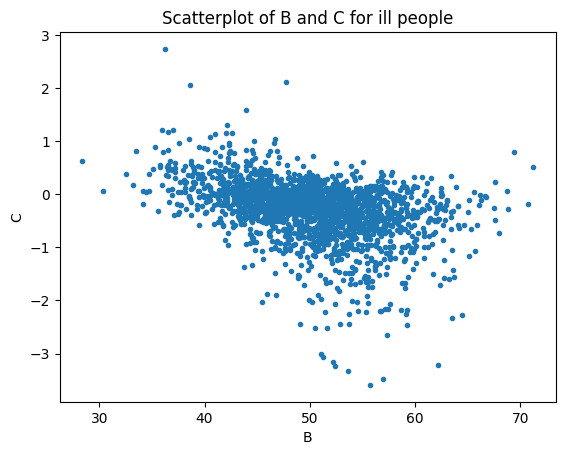

In [923]:
plt.scatter(B[index==1], C[index==1], marker=".")
plt.xlabel("B")
plt.ylabel("C")
plt.title("Scatterplot of B and C for ill people")

pearson_cor = stats.pearsonr(B[index==1], C[index==1])[0]
print(f"Pearson correlation: {pearson_cor}")

In [924]:
def calc_separation(x, y):
    
    d = np.abs(x.mean() - y.mean()) / np.sqrt(x.std(ddof=1)**2 + y.std(ddof=1)**2)
    
    return d

def get_covariance_offdiag(X, Y):
    return np.cov(X, Y, ddof=1)[0, 1]

Text(0, 0.5, 'Frequency / 0.28')

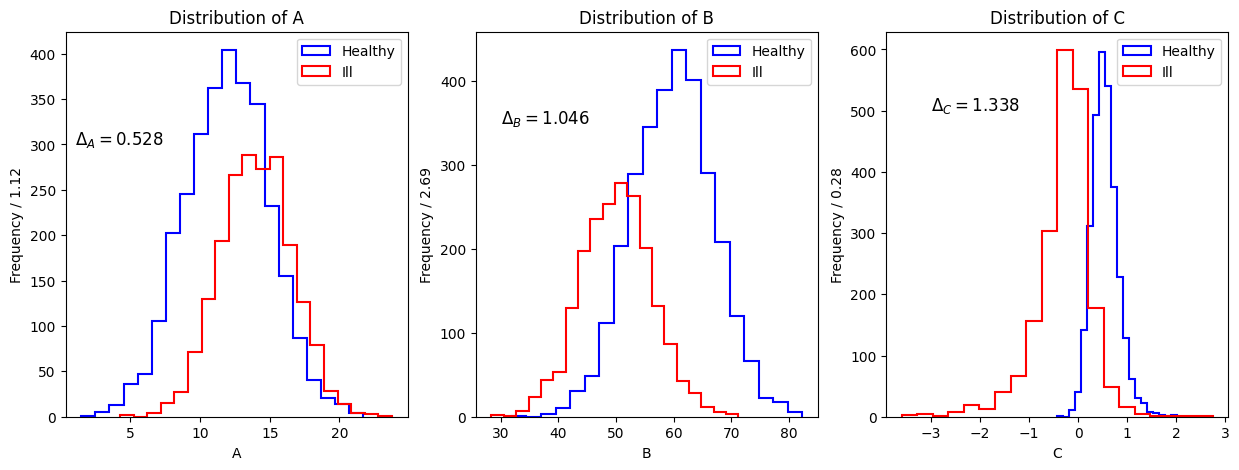

In [925]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))

ax[0].hist(A[index==0], bins=20, label="Healthy", histtype='step', color='Blue', lw=1.5);
ax[1].hist(B[index==0], bins=20, label="Healthy", histtype='step', color='Blue', lw=1.5);
ax[2].hist(C[index==0], bins=20, label="Healthy", histtype='step', color='Blue', lw=1.5);
ax[0].hist(A[index==1], bins=20, label="Ill", histtype='step', color='Red', lw=1.5);
ax[1].hist(B[index==1], bins=20, label="Ill", histtype='step', color='Red', lw=1.5);
ax[2].hist(C[index==1], bins=20, label="Ill", histtype='step', color='Red', lw=1.5);

ax[0].legend()
ax[0].set_title("Distribution of A")
ax[0].text(1, 300, fr'$\Delta_{{A}} = {calc_separation(A[index==1.0], A[index==0.0]):.3f}$', fontsize=12)
ax[0].set_xlabel("A")
ax[0].set_ylabel(f"Frequency / {(np.max(A[index==1])-np.min(A[index==0]))/20:.2f}")

ax[1].legend()
ax[1].set_title("Distribution of B")
ax[1].text(30, 350, fr'$\Delta_{{B}} = {calc_separation(B[index==1], B[index==0]):.3f}$', fontsize=12)
ax[1].set_xlabel("B")
ax[1].set_ylabel(f"Frequency / {(np.max(B[index==0])-np.min(B[index==1]))/20:.2f}")

ax[2].legend()
ax[2].set_title("Distribution of C")
ax[2].text(-3, 500, fr'$\Delta_{{C}} = {calc_separation(C[index==1], C[index==0]):.3f}$', fontsize=12)
ax[2].set_xlabel("C")
ax[2].set_ylabel(f"Frequency / {(np.max(C[index==0])-np.min(C[index==1]))/20:.2f}")

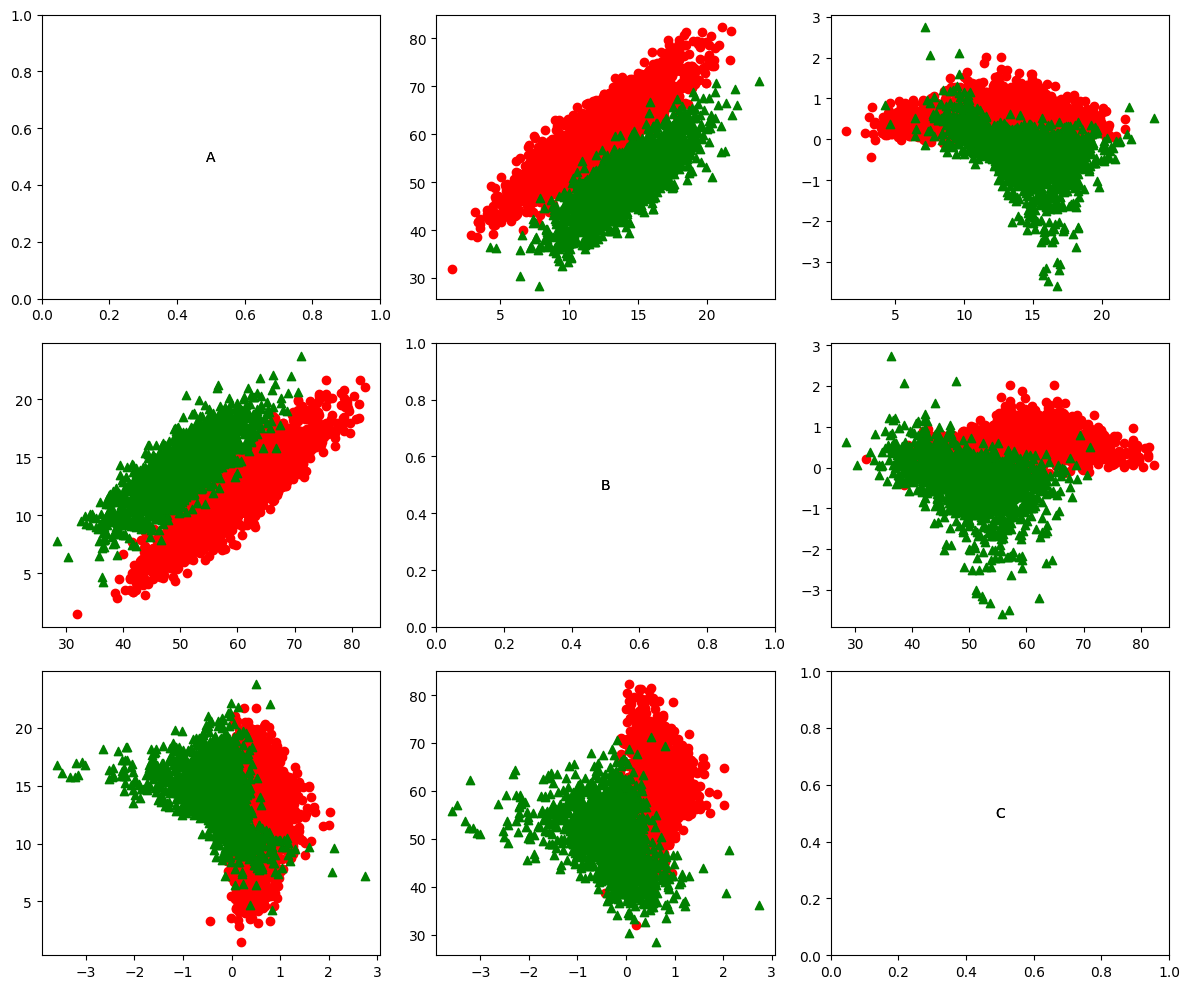

In [926]:
nvar = 3
nspec = 2
var_name = ["A", "B", "C"]
colors  = ['Red', 'Green', 'Blue']
markers = ['o', '^', 's']

# Draw 2D histograms:
fig_corr, ax_corr = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
for ivar in range(nvar):
    for jvar in range(nvar):        
        ax = ax_corr[ivar, jvar]        
        for ispec in range(nspec):        
            data_ispec = data[data[:, 0] == ispec]  # extract the relevant species
            data_ispec_ivar = data_ispec[:, ivar+2]
            data_ispec_jvar = data_ispec[:, jvar+2]                

            if ivar == jvar:       # i.e. diagonal
                ax.text(0.5, 0.5, var_name[ivar], horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            else:
                ax.scatter(data_ispec_ivar, data_ispec_jvar, marker = markers[ispec], color = colors[ispec])
                                
fig_corr.tight_layout()

In [1]:
data_healthy = np.array([A[index==0], B[index==0], C[index==0]])
data_sick = np.array([A[index==1], B[index==1], C[index==1]])

covmat_healthy = np.cov(data_healthy, ddof=1)
covmat_sick = np.cov(data_sick, ddof=1)

# The calculations requires the inverted COMBINED covariance matrices:
print("Combined covariance matrix:")
covmat_comb = covmat_healthy + covmat_sick
print(covmat_comb)
print("")

print("Inverted combined covariance matrix:")
covmat_comb_inv = np.linalg.inv(covmat_comb)
print(covmat_comb_inv)
print("")

wf = covmat_comb_inv @ (data_healthy.mean(axis=1) - data_sick.mean(axis=1))
print(f"w_f = {wf}")

NameError: name 'np' is not defined

In [928]:
fisher_data_healthy = np.zeros(len(data_healthy[0, :]))  # fill in yourself
for i in range(len(data_healthy[0, :])):
    fisher_data_healthy[i] = np.dot(wf, data_healthy[:, i])

fisher_data_sick = np.zeros(len(data_sick[0, :]))  # fill in yourself
for i in range(len(data_sick[0, :])):
    fisher_data_sick[i] = np.dot(wf, data_sick[:, i])

print(f"The separation between the samples is: {calc_separation(fisher_data_healthy, fisher_data_sick):.3f}")

The separation between the samples is: 3.236


Text(5, 350, '$\\Delta_{F} = 3.236$')

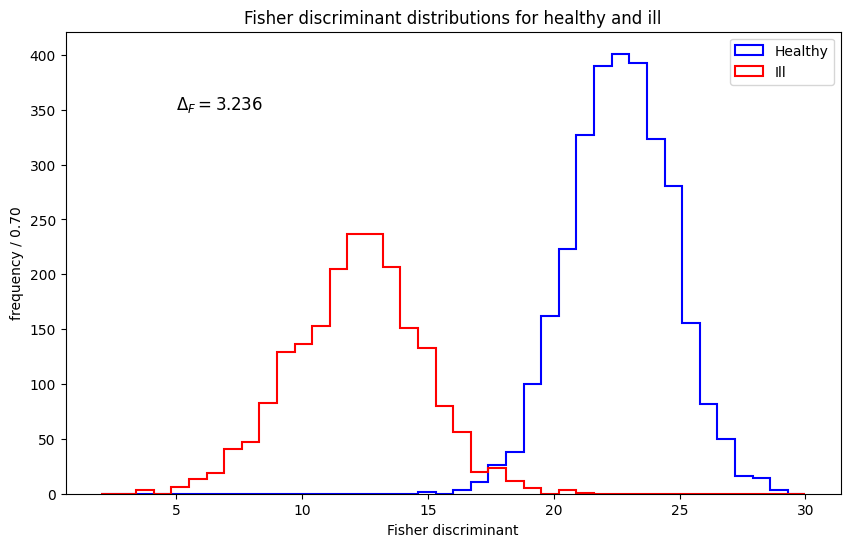

In [929]:
Nbins = 40
xmin = 2
xmax = 30
binwidth = (xmax-xmin)/Nbins


fig, ax = plt.subplots(figsize=(10,6))
hist_healthy = ax.hist(fisher_data_healthy, bins=Nbins, label="Healthy", histtype='step', color='Blue', lw=1.5, range=(xmin,xmax));
hist_ill = ax.hist(fisher_data_sick, bins=Nbins, label="Ill", histtype='step', color='Red', lw=1.5, range=(xmin,xmax));
ax.set_xlabel("Fisher discriminant")
ax.set_ylabel(f"frequency / {(xmax-xmin)/Nbins:.2f}")
ax.legend()
ax.set_title("Fisher discriminant distributions for healthy and ill")
ax.text(5, 350, fr'$\Delta_{{F}} = {calc_separation(fisher_data_healthy, fisher_data_sick):.3f}$', fontsize=12)

Fraction of ill individuals classified correctly with this cut: 0.9955
Value of the Fisher discriminant at this cut: 18.799999999999997 

False positive rate: 0.026088374368172185
False negative rate: 0.004602011249360831


Text(25, 350, 'Healthy')

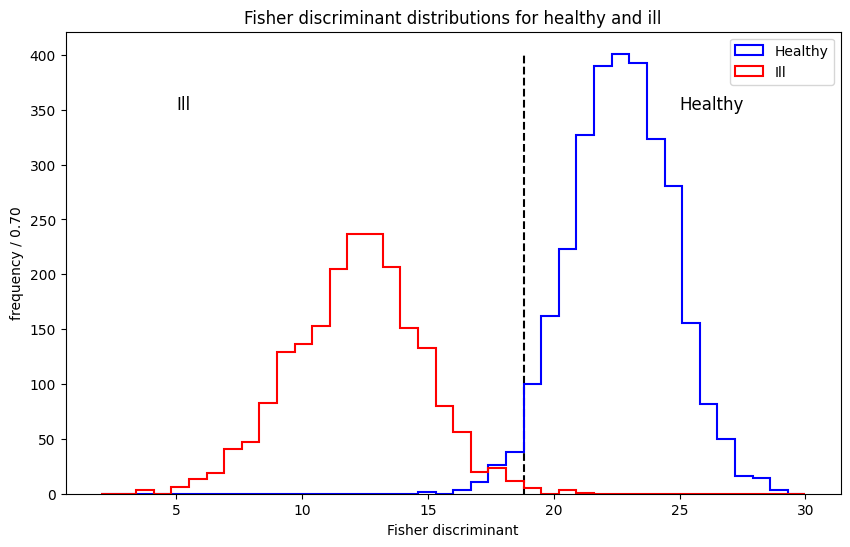

In [930]:
Nbins = 40
xmin = 2
xmax = 30
binwidth = (xmax-xmin)/Nbins

hist_healthy = np.histogram(fisher_data_healthy, bins=Nbins, range=(xmin,xmax))
hist_ill = np.histogram(fisher_data_sick, bins=Nbins, range=(xmin,xmax))

x = (hist_healthy[1][1:] + hist_healthy[1][:-1])/2

i = 24
print(f"Fraction of ill individuals classified correctly with this cut: {np.sum(hist_ill[0][:i])/np.sum(hist_ill[0])}")
print(f"Value of the Fisher discriminant at this cut: {hist_ill[1][i]} \n")

FPR = np.sum(hist_healthy[0][:i])/np.sum(hist_healthy[0]) / (np.sum(hist_healthy[0][:i])/np.sum(hist_healthy[0]) + np.sum(hist_ill[0][:i])/np.sum(hist_ill[0]))
FNR = np.sum(hist_ill[0][i:])/np.sum(hist_ill[0]) / (np.sum(hist_healthy[0][i:])/np.sum(hist_healthy[0]) + np.sum(hist_ill[0][i:])/np.sum(hist_ill[0]))

print(f"False positive rate: {FPR}")
print(f"False negative rate: {FNR}")



fig, ax = plt.subplots(figsize=(10,6))
plt.plot((hist_ill[1][i], hist_ill[1][i]), (0,400), linestyle="--", color="black")
hist_healthy = ax.hist(fisher_data_healthy, bins=Nbins, label="Healthy", histtype='step', color='Blue', lw=1.5, range=(xmin,xmax));
hist_ill = ax.hist(fisher_data_sick, bins=Nbins, label="Ill", histtype='step', color='Red', lw=1.5, range=(xmin,xmax));
ax.set_xlabel("Fisher discriminant")
ax.set_ylabel(f"frequency / {(xmax-xmin)/Nbins:.2f}")
ax.legend()
ax.set_title("Fisher discriminant distributions for healthy and ill")
ax.text(5, 350, fr'Ill', fontsize=12)
ax.text(25, 350, fr'Healthy', fontsize=12)

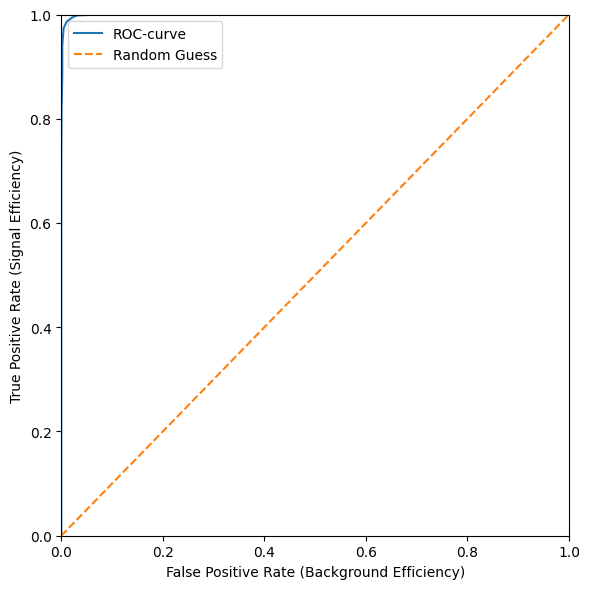

In [931]:
fig2, ax2 = plt.subplots(figsize=(6,6))

# Calculate FPR and TPR by calc_ROC:
FPR, TPR = calc_ROC(hist_healthy, hist_ill)
    
# Plot the roc-curve:
ax2.plot(FPR, TPR, '-', label="ROC-curve")

# Plot diagonal line:
ax2.plot([0, 1], [0, 1], '--', label='Random Guess')

# Set figure options:
ax2.set(xlabel='False Positive Rate (Background Efficiency)', ylabel='True Positive Rate (Signal Efficiency)', xlim=(0, 1), ylim=(0, 1))
ax2.legend()

fig2.tight_layout()

In [932]:
# Calculate ROC curve from two histograms (hist1 is signal, hist2 is background):
def calc_error_rates(hist1, hist2) :

    # First we extract the entries (y values) and the edges of the histograms:
    # Note how the "_" is simply used for the rest of what e.g. "hist1" returns (not really of our interest)
    y_sig, x_sig_edges, _ = hist1 
    y_bkg, x_bkg_edges, _ = hist2
    
    # Check that the two histograms have the same x edges:
    if np.array_equal(x_sig_edges, x_bkg_edges) :
        
        # Extract the center positions (x values) of the bins (both signal or background works - equal binning)
        x_centers = 0.5*(x_sig_edges[1:] + x_sig_edges[:-1])
        
        # Calculate the integral (sum) of the signal and background:
        integral_sig = y_sig.sum()
        integral_bkg = y_bkg.sum()
    
        # Initialize empty arrays for the True Positive Rate (TPR) and the False Positive Rate (FPR):
        FPR = np.zeros_like(y_sig) # True positive rate (sensitivity)
        FNR = np.zeros_like(y_sig) # False positive rate ()
        
        # Loop over all bins (x_centers) of the histograms and calculate TN, FP, FN, TP, FPR, and TPR for each bin:
        for i, x in enumerate(x_centers): 
            
            # The cut mask
            cut = (x_centers < x)
            
            # True positive
            TP = np.sum(y_sig[~cut]) / integral_sig    # True positives
            FP = np.sum(y_bkg[~cut]) / integral_bkg     # False positives
            FPR[i] = FP / (TP + FP)                    # False positive rate
            
            # True negative
            TN = np.sum(y_bkg[cut]) / integral_bkg      # True negatives (background)
            FN = np.sum(y_sig[cut]) / integral_sig     # False negatives
            FNR[i] = FN / (FN + TN)                     # False negative rate            
            
        return FPR, FNR
    
    else:
        AssertionError("Signal and Background histograms have different bins and/or ranges")

/var/folders/bh/qd5vvgrj3dxbcwf3jbzbldrm0000gn/T/ipykernel_4105/3375278290.py:37: RuntimeWarning: invalid value encountered in scalar divide
  FNR[i] = FN / (FN + TN)                     # False negative rate
/var/folders/bh/qd5vvgrj3dxbcwf3jbzbldrm0000gn/T/ipykernel_4105/3375278290.py:32: RuntimeWarning: invalid value encountered in scalar divide
  FPR[i] = FP / (TP + FP)                    # False positive rate


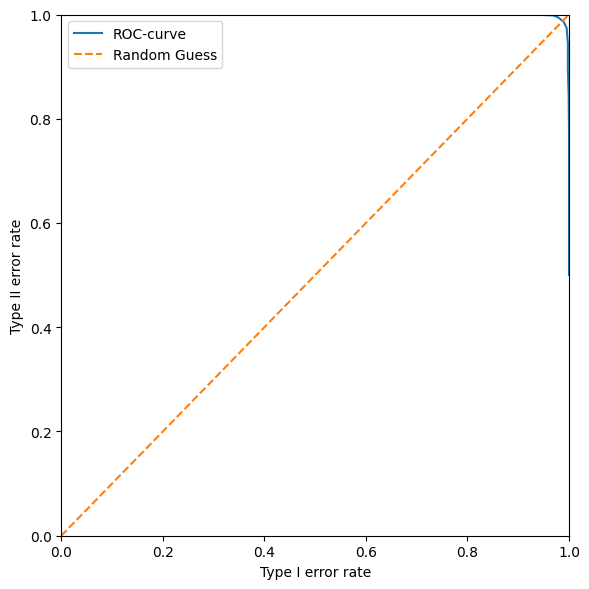

In [933]:
fig2, ax2 = plt.subplots(figsize=(6,6))

FPR, FNR = calc_error_rates(hist_ill, hist_healthy)

ax2.plot(FPR, FNR, '-', label="ROC-curve")

# Plot diagonal line:
ax2.plot([0, 1], [0, 1], '--', label='Random Guess')

# Set figure options:
ax2.set(xlabel='Type I error rate', ylabel='Type II error rate', xlim=(0, 1), ylim=(0, 1))
ax2.legend()

fig2.tight_layout()


### Problem 5.1

In [934]:
data = np.genfromtxt("data_LukeLightningLights.txt")

month = data[:,0]
income = data[:,2]
sig_income = data[:,3]

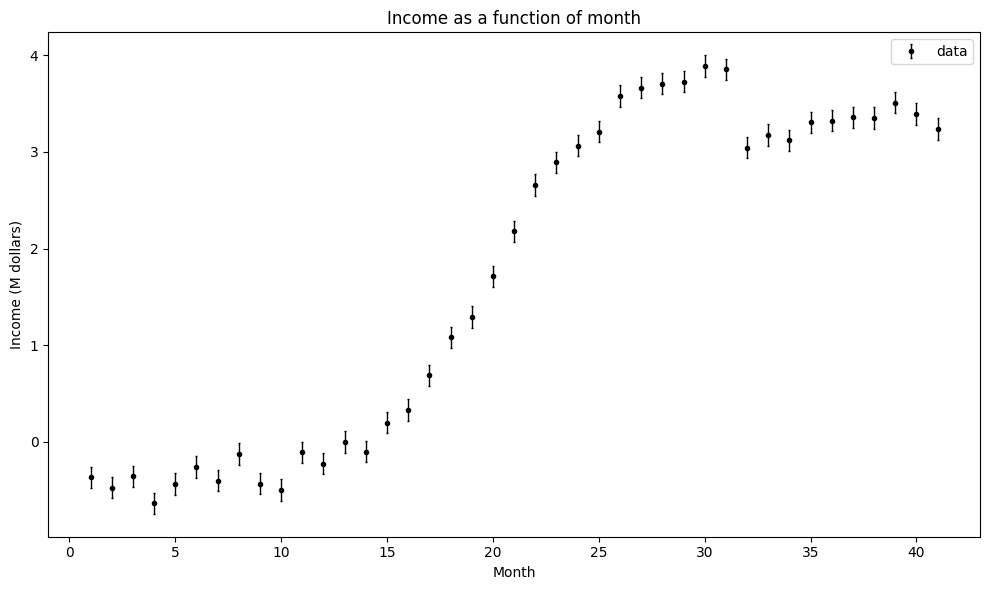

In [935]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel="Month", ylabel="Income (M dollars)", title="Income as a function of month");

ax.errorbar(month, income, yerr=sig_income, label="data", fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Add legend
ax.legend(loc='best')
fig.tight_layout()

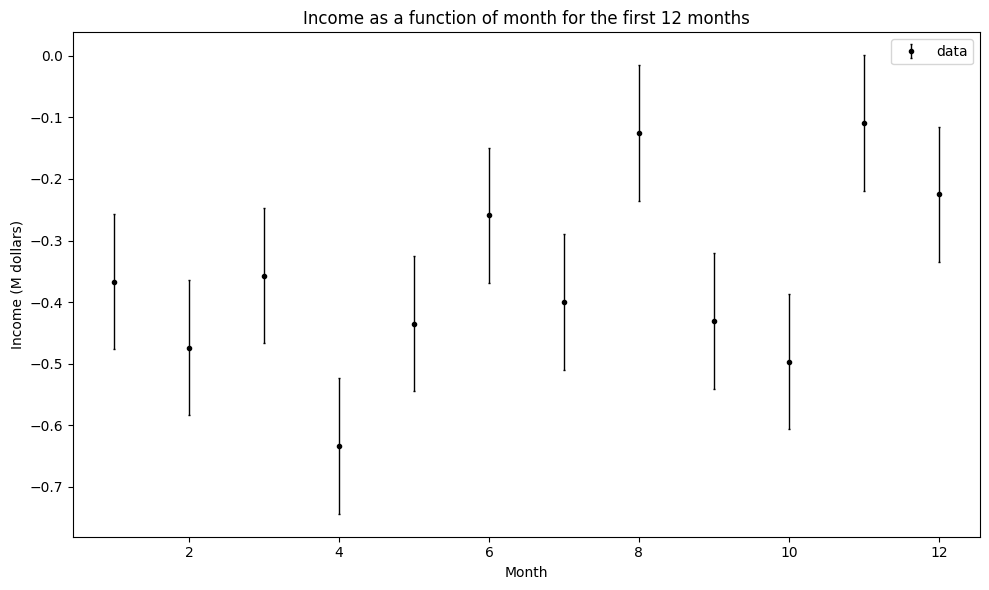

In [936]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel="Month", ylabel="Income (M dollars)", title="Income as a function of month for the first 12 months");

ax.errorbar(month[month<=12], income[month<=12], yerr=sig_income[month<=12], label="data", fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Add legend
ax.legend(loc='best')
fig.tight_layout()

In [937]:
def mean_weighted(x, dx):
    return np.sum(x/dx**2) / np.sum(1/dx**2)

def err_weighted(dx):
    return np.sqrt(1 / np.sum(1/dx**2))

def chi2(x, dx, mean_w):
    return np.sum((x - mean_w)**2 / dx**2)

def chi2_prob(chi2_value, x):
    Ndof = len(x) - 1
    return stats.chi2.sf(chi2_value, Ndof)

In [938]:
weighted_mean = mean_weighted(income[month<=12], sig_income[month<=12])
weighted_error = err_weighted(sig_income[month<=12])

print(f"The weighted mean of the income is {weighted_mean} +- {weighted_error}")
print(f"chi2 = {chi2(income[month<=12], sig_income[month<=12], weighted_mean)}")
print(f"Ndof = {len(income[month<=12])-1}")
print(f"prob = {chi2_prob(chi2(income[month<=12], sig_income[month<=12], weighted_mean), income[month<=12])}")

The weighted mean of the income is -0.3594166666666666 +- 0.031754264805429415
chi2 = 21.968009641873277
Ndof = 11
prob = 0.024622251837895934


Fit value: a = 0.02848 +/- 0.00729
Fit value: b = -0.52902 +/- 0.06210
Chi2 value: 20.6   Ndof = 12    Prob(Chi2,Ndof) = 0.05671879429381484


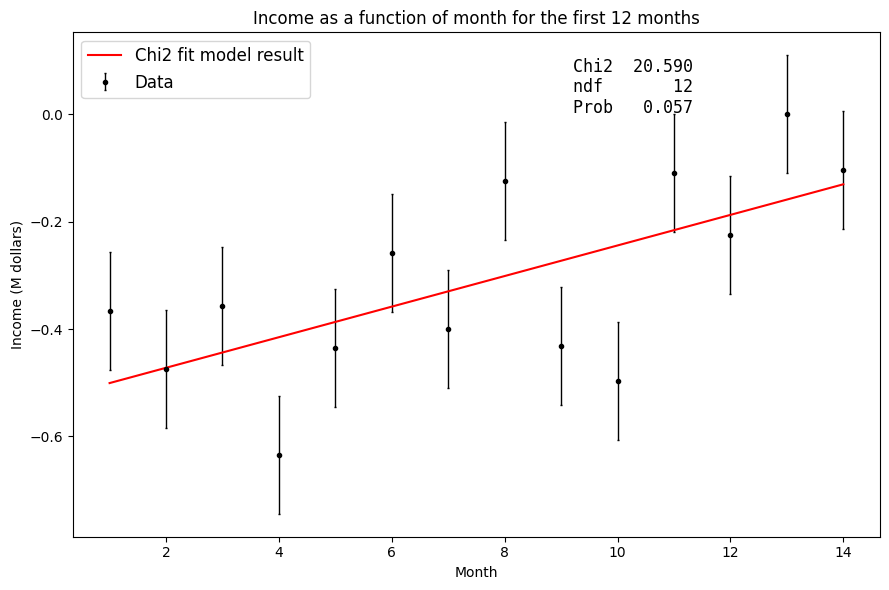

In [939]:
def linear(x, a, b):
    return a*x+b

stop_month = 14

fit_and_plot(linear, month[month<=stop_month], income[month<=stop_month], sig_income[month<=stop_month], {"a":0, "b":0}, ["Month", "Income (M dollars)", "Income as a function of month for the first 12 months"])

Fit value: k = 0.36291 +/- 0.02034
Fit value: x0 = 20.00486 +/- 0.16648
Fit value: a = 4.37543 +/- 0.09186
Fit value: b = -0.42457 +/- 0.03753
Fit value: change = -0.65123 +/- 0.07676
Chi2 value: 36.9   Ndof = 36    Prob(Chi2,Ndof) = 0.42912624382336717


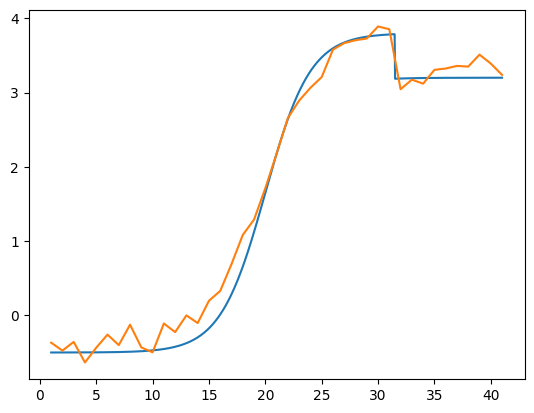

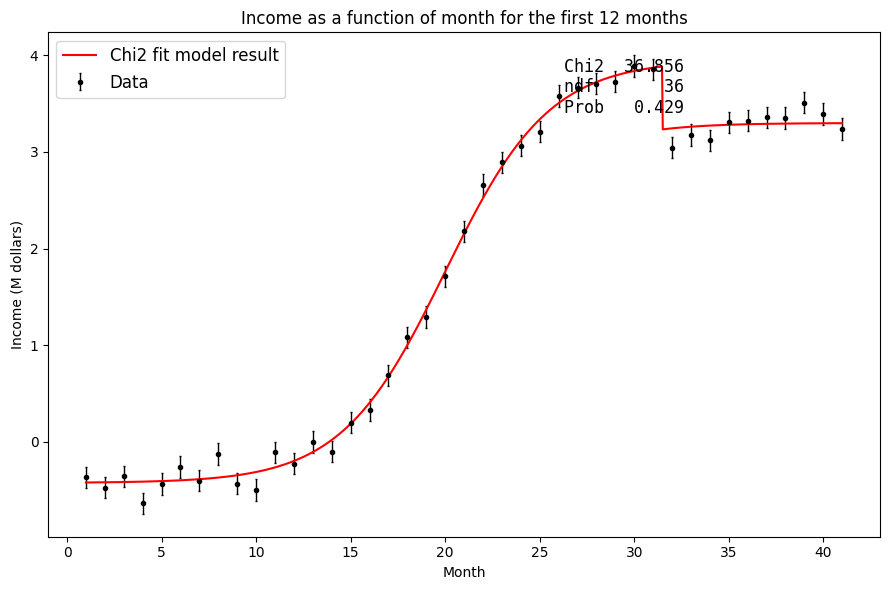

In [940]:
def logistic_discon(x, k, x0, a, b, change):
    if x <= 31.5:
        return a / (1 + np.exp(-k*(x-x0))) + b
    elif x > 31.5:
        return a / (1 + np.exp(-k*(x-x0))) + b + change

logistic_discon_vec = np.vectorize(logistic_discon)

xaxis = np.linspace(1, 41, 1000)

plt.plot(xaxis, logistic_discon_vec(xaxis, 0.5, 20, 4.3, -0.5, -0.6))
plt.plot(month, income)

minuit_chi2 = fit(logistic_discon, month, income, sig_income, {"k":0.5, "x0":20, "a":4.3, "b":-0.5, "change":0.6})
plot(logistic_discon_vec, month, income, sig_income, ["Month", "Income (M dollars)", "Income as a function of month for the first 12 months"])

### Problem 5.2

In [941]:
t_res = np.genfromtxt("data_TimeResiduals.txt")

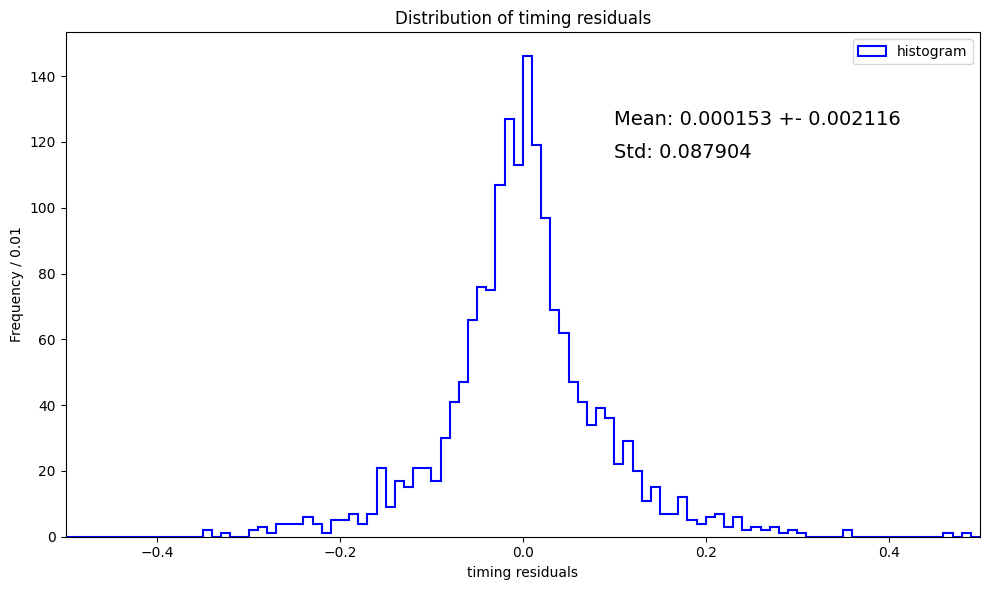

In [958]:
N_bins = 100
xmin = -0.5
xmax = 0.5
binwidth = (xmax-xmin)/N_bins

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel="timing residuals", ylabel=f"Frequency / {binwidth:.2f}", xlim=(xmin, xmax), title="Distribution of timing residuals");

ax.hist(t_res, bins=N_bins, range=(xmin, xmax), histtype='step', color="blue", label='histogram', lw=1.5)
# Add legend
ax.legend(loc='best')
ax.text(0.1, 125, fr'Mean: {np.mean(t_res):.6f} +- {np.std(t_res, ddof=1)/np.sqrt(len(t_res)):.6f}', fontsize=14)
ax.text(0.1, 115, fr'Std: {np.std(t_res, ddof=1):.6f}', fontsize=14)
fig.tight_layout()


In [943]:
t_res_cleaned, _, t_res_rejected, p_rejected = chauvenet(t_res, np.zeros(len(t_res)), p_reject=0.01)

  The number of measurements used before and after is: 1726 and 1686
  This means that 40 measurements have been removed


The rejected data points are: [0.354, 0.287, 0.304, -0.321, -0.29, 0.463, -0.606, 0.295, -0.294, -0.286, 0.483, -0.349, -0.282, -0.341, 0.294, 0.354, -0.297, 0.354, 0.287, 0.304, -0.321, -0.29, 0.463, -0.606, 0.295, -0.294, -0.286, 0.483, -0.349, -0.282, -0.341, 0.294, 0.354, 0.354, 0.287, 0.304, -0.321, -0.29, 0.463, -0.606, 0.295, -0.294, -0.286, 0.483, -0.349, -0.282, -0.341, 0.294, 0.354, 0.287, 0.304, -0.321, -0.29, 0.463, -0.606, 0.295, -0.294, -0.286, 0.483, -0.349, -0.282, -0.341, 0.354, 0.287, 0.304, -0.321, -0.29, 0.463, 0.278, -0.606, 0.295, -0.294, -0.286, 0.483, -0.349, -0.282, 0.354, 0.287, 0.304, -0.321, -0.29, 0.463, 0.278, -0.606, 0.295, -0.294, -0.286, 0.483, -0.349, 0.354, 0.277, 0.287, 0.304, -0.321, -0.29, 0.463, 0.278, -0.606, 0.295, -0.294, -0.286, 0.483, 0.354, 0.277, 0.287, 0.304, -0.321, -0.29, 0.463, 0.278, -0.606, 0.295, -0.294, -0.286, 0.276, 0.354, 0.277, 0.287, 0.304, -0.321, -0.29, 0.463, 0.278, -0.606, 0.295, -0.294, -0.286, 0.354, 0.277, 0.287, -0.272,

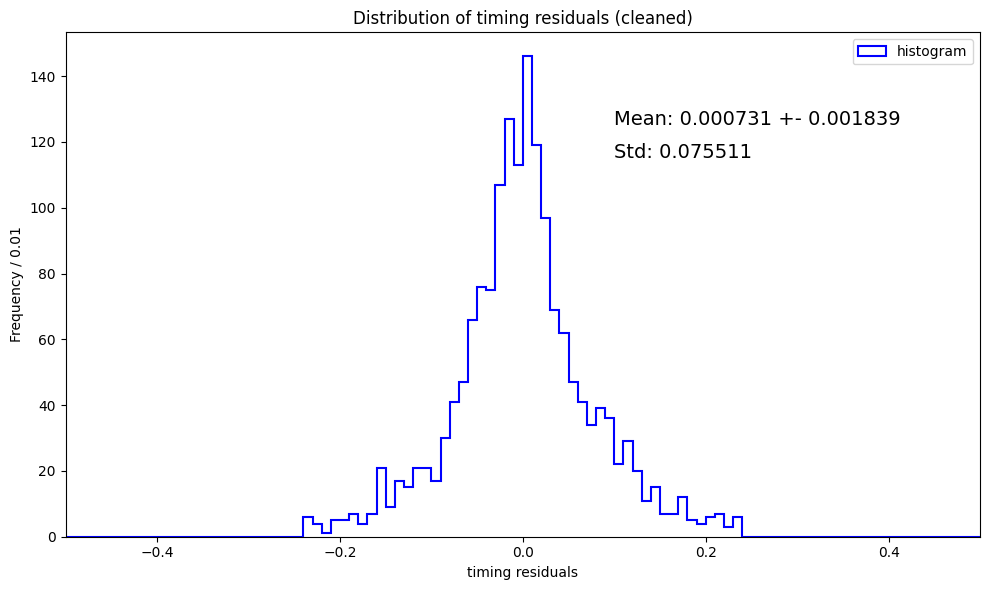

In [959]:
N_bins = 100
xmin = -0.5
xmax = 0.5
binwidth = (xmax-xmin)/N_bins

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel="timing residuals", ylabel=f"Frequency / {binwidth:.2f}", xlim=(xmin, xmax), title="Distribution of timing residuals (cleaned)");

ax.hist(t_res_cleaned, bins=N_bins, range=(xmin, xmax), histtype='step', color="blue", label='histogram', lw=1.5)
# Add legend
ax.legend(loc='best')
ax.text(0.1, 125, fr'Mean: {np.mean(t_res_cleaned):.6f} +- {np.std(t_res_cleaned, ddof=1)/np.sqrt(len(t_res_cleaned)):.6f}', fontsize=14)
ax.text(0.1, 115, fr'Std: {np.std(t_res_cleaned, ddof=1):.6f}', fontsize=14)
fig.tight_layout()

print(f"The rejected data points are: {t_res_rejected}")
print(f"These have a probability of: {p_rejected}")


Fit value: mu = 0.00078 +/- 0.00153
Fit value: sigma = 0.06716 +/- 0.00189
Chi2 value: 232.7   Ndof = 64    Prob(Chi2,Ndof) = 5.363111137293021e-21


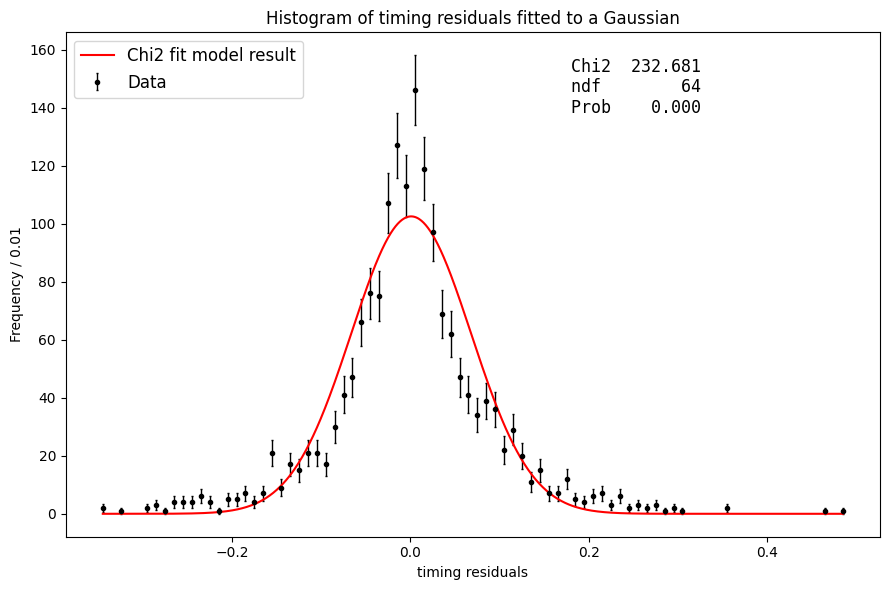

In [960]:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    N = (xmax-xmin)/N_bins * len(t_res)
    return  N * 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(t_res, bins=N_bins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

fit_and_plot(gauss_pdf, x, y, sy, {"mu":0.0, "sigma":0.1}, ["timing residuals", f"Frequency / {(xmax-xmin)/N_bins:.2f}", "Histogram of timing residuals fitted to a Gaussian"])

Fit value: gamma = 0.04154 +/- 0.00147
Fit value: x0 = -0.00128 +/- 0.00153
Chi2 value: 90.1   Ndof = 64    Prob(Chi2,Ndof) = 0.017545103634783305


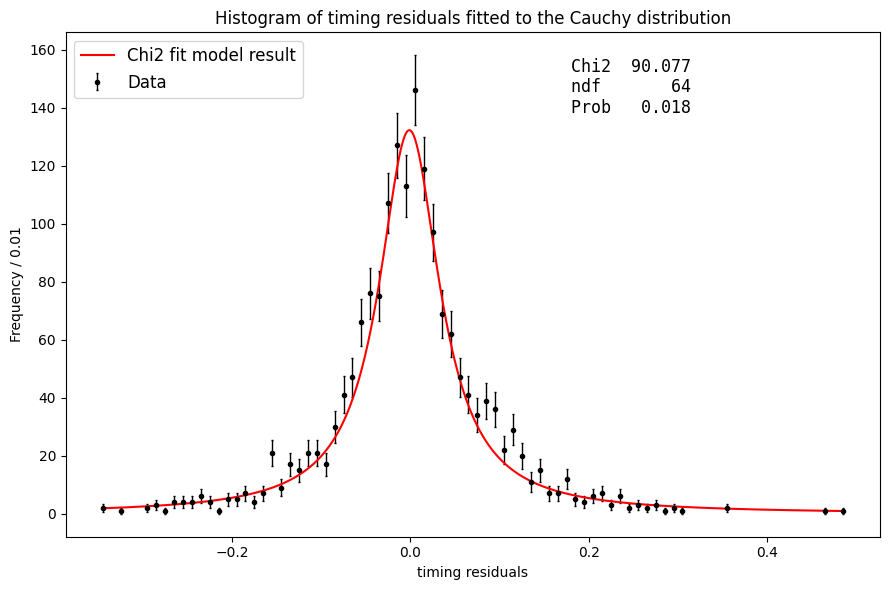

In [961]:
def cauchy_pdf(x, gamma, x0):
    N = (xmax-xmin)/N_bins * len(t_res)
    return  N * 1 / np.pi * (gamma / ((x-x0)**2 + gamma**2))

fit_and_plot(cauchy_pdf, x, y, sy, {"gamma":0.1, "x0":0.0}, ["timing residuals", f"Frequency / {(xmax-xmin)/N_bins:.2f}", "Histogram of timing residuals fitted to the Cauchy distribution"])

Fit value: f_core = 0.46427 +/- 0.06073
Fit value: sigma_core = 0.03406 +/- 0.00355
Fit value: sigma_tail = 0.10183 +/- 0.00674
Chi2 value: 86.4   Ndof = 63    Prob(Chi2,Ndof) = 0.026856856369963076


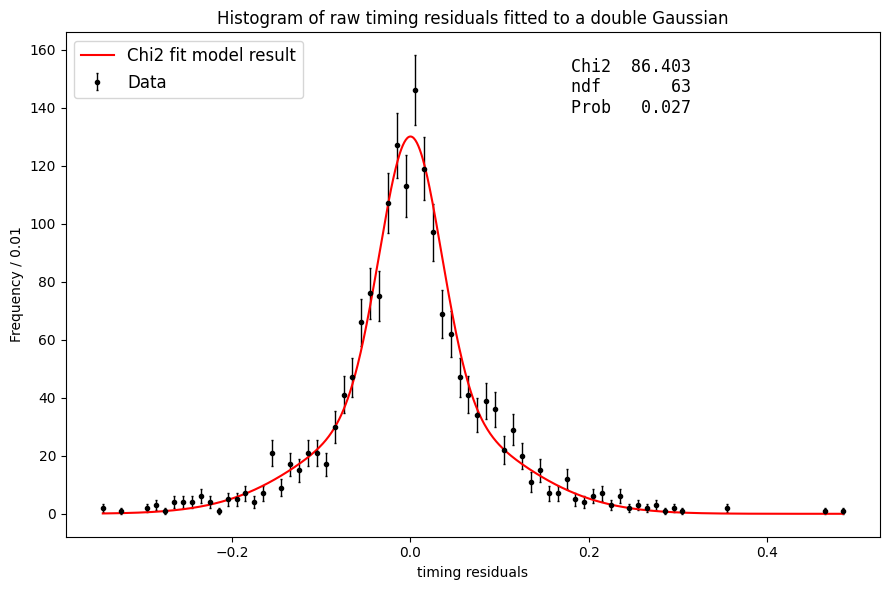

In [962]:
def double_gauss_pdf(x, f_core, sigma_core, sigma_tail) :
    """Gaussian"""
    N = (xmax-xmin)/N_bins * len(t_res)
    return  N * (f_core / np.sqrt(2*np.pi) / sigma_core * np.exp( -0.5 * (x)**2 / sigma_core**2) + (1-f_core) / np.sqrt(2*np.pi) / sigma_tail * np.exp( -0.5 * (x)**2 / sigma_tail**2))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(t_res, bins=N_bins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

fit_and_plot(double_gauss_pdf, x, y, sy, {"f_core":0.2, "sigma_core":0.1, "sigma_tail":0.3}, ["timing residuals", f"Frequency / {(xmax-xmin)/N_bins:.2f}", "Histogram of raw timing residuals fitted to a double Gaussian"])

Fit value: f_core = 0.46265 +/- 0.06172
Fit value: sigma_core = 0.03397 +/- 0.00361
Fit value: sigma_tail = 0.10165 +/- 0.00681
Chi2 value: 83.4   Ndof = 63    Prob(Chi2,Ndof) = 0.04353039033670776


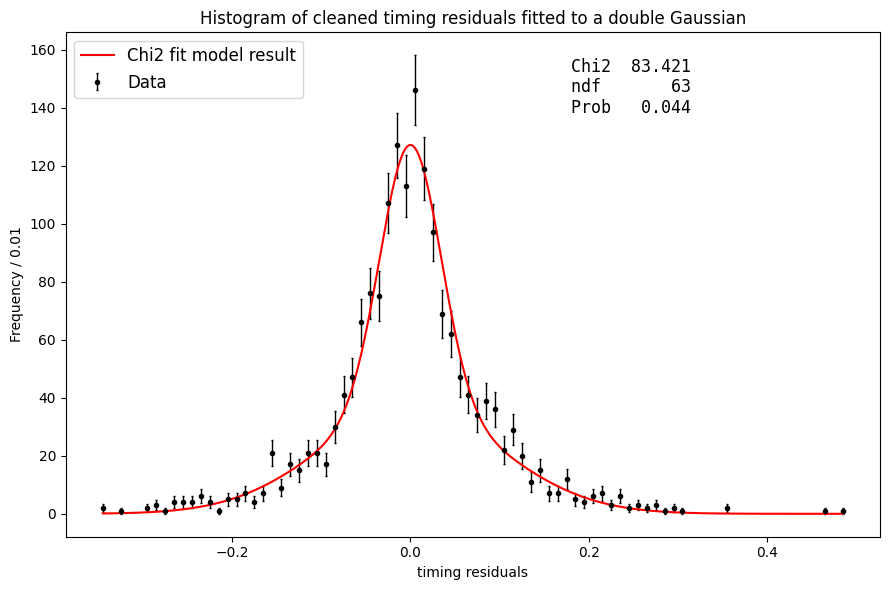

In [963]:
def double_gauss_pdf(x, f_core, sigma_core, sigma_tail) :
    """Gaussian"""
    N = (xmax-xmin)/N_bins * len(t_res_cleaned)
    return  N * (f_core / np.sqrt(2*np.pi) / sigma_core * np.exp( -0.5 * (x)**2 / sigma_core**2) + (1-f_core) / np.sqrt(2*np.pi) / sigma_tail * np.exp( -0.5 * (x)**2 / sigma_tail**2))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(t_res, bins=N_bins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.

fit_and_plot(double_gauss_pdf, x, y, sy, {"f_core":0.2, "sigma_core":0.1, "sigma_tail":0.3}, ["timing residuals", f"Frequency / {(xmax-xmin)/N_bins:.2f}", "Histogram of cleaned timing residuals fitted to a double Gaussian"])